In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import tensorflow_datasets as tfds

## Citation

```
@inproceedings{bossard14,
  title = {Food-101 -- Mining Discriminative Components with Random Forests},
  author = {Bossard, Lukas and Guillaumin, Matthieu and Van Gool, Luc},
  booktitle = {European Conference on Computer Vision},
  year = {2014}
}
```

In [3]:
ds, ds_info = tfds.load('food101', shuffle_files=True, as_supervised=True, with_info=True)

In [4]:
train_ds, valid_ds = ds["train"], ds["validation"]

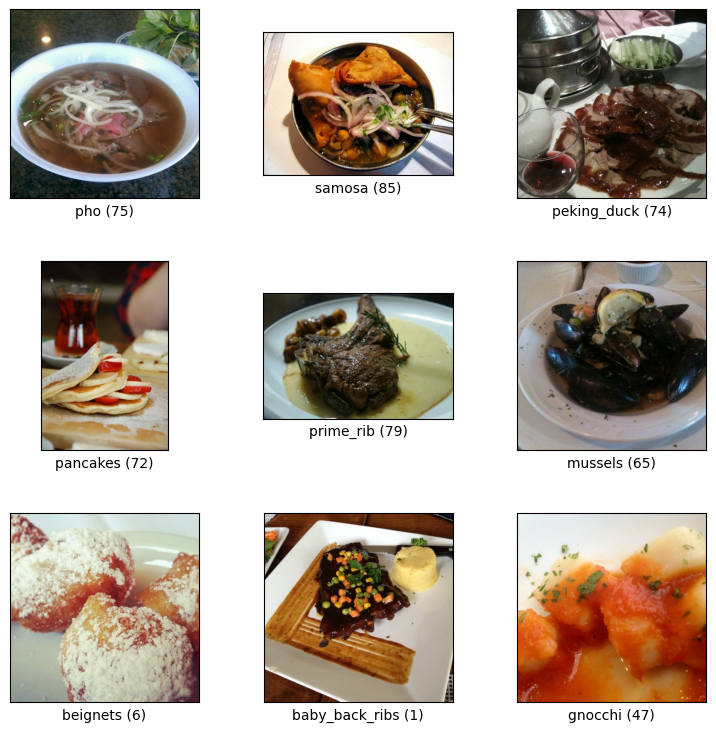

In [5]:
fig = tfds.show_examples(train_ds, ds_info)

In [6]:
MAX_SIDE_LEN = 128
HOT_DOG_CLASS = 55
train_ds = train_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype=tf.int32), tf.cast(label == HOT_DOG_CLASS, dtype=tf.int32))
)
valid_ds = valid_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype=tf.int32), tf.cast(label == HOT_DOG_CLASS, dtype=tf.int32))
)

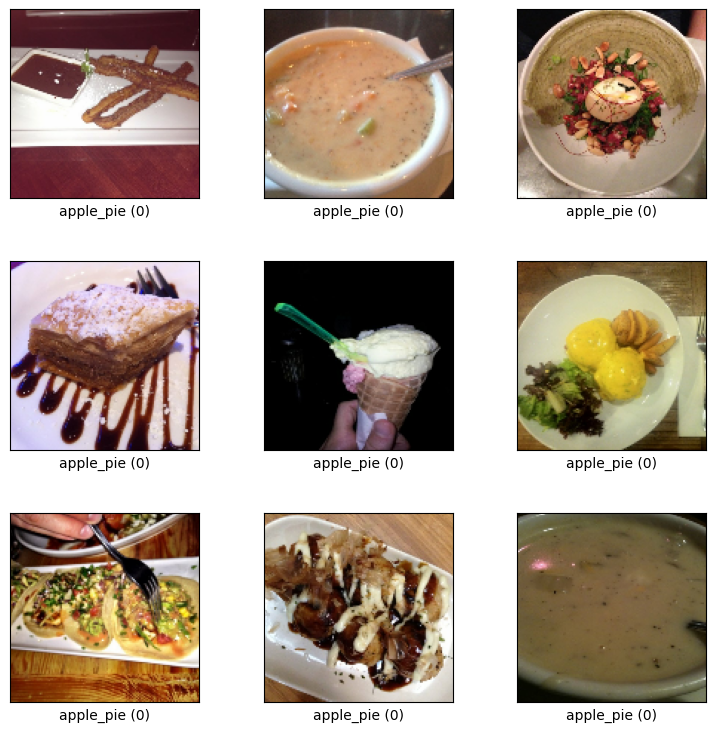

In [7]:
fig = tfds.show_examples(train_ds, ds_info)

In [8]:
#This line sets the sizes for the training and validation datasets
train_hd_size, valid_hd_size = 750, 250
#This line creates a new dataset, train_hotdogs, by filtering the original dataset train_ds to include only those samples where the label is 1
#making the dataset repeat itself 3 times. This means each hotdog sample will appear three times in the train_hotdogs dataset
train_hotdogs = train_ds.filter(lambda _, label: label == 1).repeat(3)
#This line creates a new dataset, train_hotdogs, by filtering the original dataset train_ds to include only those samples where the label is 0
train_nothotdogs = train_ds.filter(lambda _, label: label == 0)

In [9]:
valid_hotdogs = valid_ds.filter(lambda _, label: label == 1).repeat(3)
valid_nothotdogs = valid_ds.filter(lambda _, label: label == 0)

In [11]:
valid_hotdogs

<_RepeatDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [13]:
#the model will process 16 samples at a time during each training step. 1 image (no) 16 image (yes)
batch_size = 16
#create a new dataset by sampling from multiple datasets,both train_hotdogs and train_nothotdogs are given equal probability (0.5 each)
#both train_hotdogs and train_nothotdogs are given equal probability (0.5 each)
#stop_on_empty_dataset=True means that the sampling will stop once any of the source datasets is exhausted.
train_ds = tf.data.Dataset.sample_from_datasets([train_hotdogs, train_nothotdogs], weights=[0.5, 0.5], stop_on_empty_dataset=True)
#caches the dataset in memory to avoid the cost (speed up the process)
#groups the dataset into batches of size 16. This means each element of train_ds will be a batch of 16 samples.
#By prefetching, the data loading and preprocessing are done in parallel with model training, improving overall training speed.
#tf.data.AUTOTUNE allows TensorFlow to determine the optimal number of batches to prefetch based on system performance and available resources.
train_ds = train_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

valid_ds = tf.data.Dataset.sample_from_datasets([valid_hotdogs, valid_nothotdogs], weights=[0.5, 0.5], stop_on_empty_dataset=True)
valid_ds = valid_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [14]:
for image, label in train_ds.take(3):
  print(image[0][0][0])
  print(label)

tf.Tensor([1 1 1], shape=(3,), dtype=int32)
tf.Tensor([1 1 1 0 1 0 0 0 1 1 1 0 1 0 0 1], shape=(16,), dtype=int32)
tf.Tensor([220 233 242], shape=(3,), dtype=int32)
tf.Tensor([1 1 0 0 0 1 1 1 1 1 1 0 0 0 1 1], shape=(16,), dtype=int32)
tf.Tensor([1 2 0], shape=(3,), dtype=int32)
tf.Tensor([0 1 0 1 1 0 1 0 0 0 1 0 0 1 0 1], shape=(16,), dtype=int32)


# Neural Network implementation (CNN)

In [ ]:
#tf.keras.Sequential([...]): This creates a sequential model that applies a series of layers sequentially.
#This layer randomly flips the input images horizontally (left to right).
#This layer randomly rotates the input images by a factor of 0.2.

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [15]:
random.seed(0)
#This line initializes a Sequential model. A Sequential model is a linear stack of layers
model = models.Sequential()
#This layer scales the input values to the range [0, 1]
model.add(layers.Rescaling(1./255))
#This adds a 2D convolutional layer with 128 filters, each of size 3x3.
#activation='relu' applies the ReLU (Rectified Linear Unit) activation function to the output of the convolution.
#input_shape=(MAX_SIDE_LEN, MAX_SIDE_LEN, 3) specifies the shape of the input data. This should be the size of the images
#(assumed to be square with side length MAX_SIDE_LEN) and the number of color channels (3 for RGB images).
model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(MAX_SIDE_LEN, MAX_SIDE_LEN, 3)))
#This layer performs max pooling, which reduces the spatial dimensions (width and height) of the input by taking the maximum value in each 2x2 pool.
model.add(layers.MaxPooling2D((2, 2)))
#During training, dropout randomly sets 25% of the input units to 0 at each update to help prevent overfitting
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
#The Flatten layer converts the 2D matrix of features into a 1D vector. This is necessary because the next layer (Dense) expects a 1D input.
model.add(layers.Flatten())
#This adds a fully connected (dense) layer with 128 units and a ReLU activation function.
#Dense layers are used to perform the final classification, combining all the features learned by the convolutional layers.
model.add(layers.Dense(128, activation='relu'))
#This adds another dropout layer with a dropout rate of 0.25, meaning 25% of the neurons will be randomly set to 0 during training
model.add(layers.Dropout(0.25))
#This adds a final dense layer with a single unit. This layer is typically used for binary classification tasks,
#where the model outputs a single value that can be interpreted as the probability of the positive class (e.g., hotdog or not-hotdog)
model.add(layers.Dense(1))

In [16]:
#prepares the model for training by configuring the optimizer, loss function, and metrics.
lr = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# training the compiled convolutional neural network (CNN) model using the training dataset,
# validating it on the validation dataset, and setting the number of training epochs for 50
epochs=10
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs,
  verbose=1
)
#verbose : means progress bars will be displayed showing the loss and accuracy metrics for both training and validation datasets during training.

Epoch 1/10
278/278 [==============================] - 441s 2s/step - loss: 0.6628 - accuracy: 0.6845 - val_loss: 0.6960 - val_accuracy: 0.6607
Epoch 2/10
278/278 [==============================] - 441s 2s/step - loss: 0.6041 - accuracy: 0.7370 - val_loss: 0.6948 - val_accuracy: 0.6779
Epoch 3/10
278/278 [==============================] - 444s 2s/step - loss: 0.5481 - accuracy: 0.7701 - val_loss: 0.7201 - val_accuracy: 0.6600
Epoch 4/10
157/278 [===============>..............] - ETA: 2:58 - loss: 0.4992 - accuracy: 0.8065

In [18]:
# visualizing a batch of images and their corresponding labels from the validation dataset
plt.figure(figsize=(10, 10))
for image_batch, label_batch in valid_ds.take(1): #takes one batch of data from the validation dataset.
  images = image_batch
  labels = label_batch

<Figure size 1000x1000 with 0 Axes>

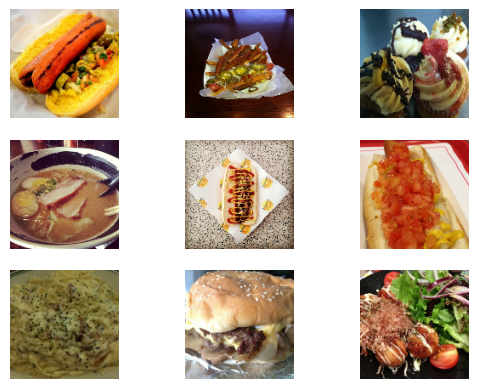

In [19]:
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(images[i])
  plt.axis("off")

In [20]:
labels[:9]

<tf.Tensor: shape=(9,), dtype=int32, numpy=array([1, 1, 0, 0, 1, 1, 0, 0, 0], dtype=int32)>